In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import functions.token_functions as tf
import spacy
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from collections import defaultdict
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

In [2]:
nlp = spacy.load('en_core_web_sm')
sw = stopwords.words("english")

In [3]:
# Create an empty list to store the review dataframes
df_list = []
csv_files = os.listdir('../data/games',)

# Iterate over each file in the folder
for file in csv_files:
    # Read the CSV file into a datadrame
    df = pd.read_csv('../data/games/'+file, index_col=0)

    # Append the dataframe to the list
    df_list.append(df)

# Combine the dataframes into a single dataframe
games_df = pd.concat(df_list, ignore_index=True)


In [4]:
# Create an empty list to store the review dataframes
df_list = []
csv_files = os.listdir('../data/books',)

# Iterate over each file in the folder
for file in csv_files:
    # Read the CSV file into a datadrame
    df = pd.read_csv('../data/books/'+file, index_col=0)

    # Append the dataframe to the list
    df_list.append(df)

# Combine the dataframes into a single dataframe
books_df = pd.concat(df_list, ignore_index=True)

In [5]:
# Create an empty list to store the review dataframes
df_list = []
csv_files = os.listdir('../data/movies',)

# Iterate over each file in the folder
for file in csv_files:
    # Read the CSV file into a datadrame
    df = pd.read_csv('../data/movies/'+file, index_col=0)

    # Append the dataframe to the list
    df_list.append(df)

# Combine the dataframes into a single dataframe
movies_df = pd.concat(df_list, ignore_index=True)

In [6]:
movies_df.rename({'movie_title': 'title'}, axis = 1, inplace = True)
books_df.rename({'movie_title': 'title'}, axis = 1, inplace = True)
games_df.rename({'game_title': 'title'}, axis = 1, inplace = True)

In [7]:
movies_df['media'] = 'movie'
books_df['media'] = 'book'
games_df['media'] = 'game'

In [8]:
all_df = pd.concat([movies_df, books_df, games_df], axis = 0)
all_df.head()

,name,title,review_title,review,rating,date_place,media
0,Not bad at all,2 Fast 2 Furious,Love this movie,Truly one of my faves. It’s a must watch if yo...,5.0,"Reviewed in the United States 🇺🇸 on May 11, 2023",movie
1,Coleman,2 Fast 2 Furious,Fast n furious,I LOVE ALL THEIR MOVIES LOL,5.0,"Reviewed in the United States 🇺🇸 on May 16, 2023",movie
2,Jack Pocock,2 Fast 2 Furious,American Masterpiece,If you didn't enjoy this movie--- you're wrong...,5.0,"Reviewed in the United States 🇺🇸 on April 28, ...",movie
3,Tina,2 Fast 2 Furious,Satisfied,Kids love these movies,5.0,"Reviewed in the United States 🇺🇸 on April 25, ...",movie
4,N.Maletich,2 Fast 2 Furious,Classic,Will always live in my heart forever and be on...,5.0,"Reviewed in the United States 🇺🇸 on March 22, ...",movie


In [9]:
# drop values
all_df = all_df.dropna()

# drop non english reviews
all_df['lang'] = all_df['review'].apply(tf.detect_language)

all_df = all_df.query('lang == "en"')


In [10]:
all_df['review_tokens'] = all_df['review'].apply(tf.clean_tokenize)
all_df['review_title_tokens'] = all_df['review_title'].apply(tf.clean_tokenize)

In [11]:
all_df.groupby(['rating'])['review'].count()

rating
1.0     6475
2.0     3899
3.0     6465
4.0    12783
5.0    91520
Name: review, dtype: int64

In [12]:
all_df.groupby(['media'])['review'].count()

media
book     100083
game       1286
movie     19773
Name: review, dtype: int64

In [13]:
all_df['sentiment'] = 0
all_df.loc[all_df['rating']>3, 'sentiment'] = 1
all_df.loc[all_df['rating']<=3, 'sentiment'] = 0

<AxesSubplot:xlabel='sentiment', ylabel='count'>

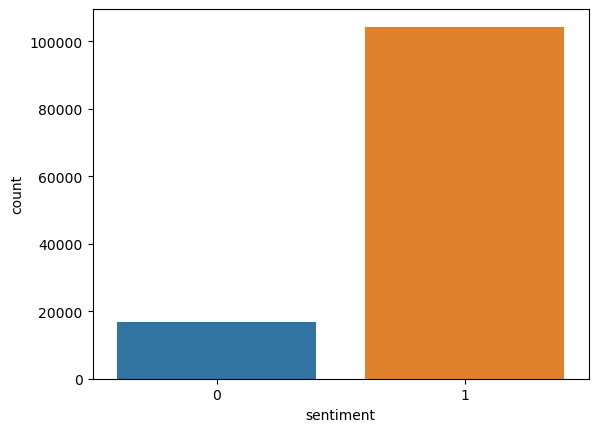

In [14]:
sns.countplot(x=all_df['sentiment'])

## Split Data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(all_df['review'], all_df['sentiment'], test_size=0.20, random_state=10, stratify=all_df['sentiment'])

In [16]:
tf.sentiment_stats(X_train, X_test, y_train, y_test)

Size of Training Data  96913
Size of Test Data  24229
Distribution of classes in Training Data :
Positive Sentiment  86.099904037642
Negative Sentiment  13.900095962357991
Distribution of classes in Testing Data :
Positive Sentiment  86.09930248875315
Negative Sentiment  13.900697511246854


## Vectorize Data

In [17]:
all_df.head()

,name,title,review_title,review,rating,date_place,media,lang,review_tokens,review_title_tokens,sentiment
0,Not bad at all,2 Fast 2 Furious,Love this movie,Truly one of my faves. It’s a must watch if yo...,5.0,"Reviewed in the United States 🇺🇸 on May 11, 2023",movie,en,"[truly, one, faves, it’s, must, watch, you’re,...","[love, movie]",1
1,Coleman,2 Fast 2 Furious,Fast n furious,I LOVE ALL THEIR MOVIES LOL,5.0,"Reviewed in the United States 🇺🇸 on May 16, 2023",movie,en,"[love, movies, lol]","[fast, n, furious]",1
2,Jack Pocock,2 Fast 2 Furious,American Masterpiece,If you didn't enjoy this movie--- you're wrong...,5.0,"Reviewed in the United States 🇺🇸 on April 28, ...",movie,en,"[didnt, enjoy, movie, youre, wrong, fun, parties]","[american, masterpiece]",1
3,Tina,2 Fast 2 Furious,Satisfied,Kids love these movies,5.0,"Reviewed in the United States 🇺🇸 on April 25, ...",movie,en,"[kids, love, movies]",[satisfied],1
4,N.Maletich,2 Fast 2 Furious,Classic,Will always live in my heart forever and be on...,5.0,"Reviewed in the United States 🇺🇸 on March 22, ...",movie,en,"[always, live, heart, forever, one, best, ones...",[classic],1


In [75]:
# balancing the dataset via downsampling
print(len(all_df[all_df['sentiment']==1]))
print(len(all_df[all_df['sentiment']==0]))
all_neg = all_df[all_df['sentiment']==0]
all_pos = all_df[all_df['sentiment']==1]

downsampled = resample(all_pos, replace=True, n_samples = 16839, random_state = 33)
final_df = pd.concat([all_neg, downsampled])

104303
16839


In [58]:
# vectorizing the review data for topic modelling
count = CountVectorizer(min_df = 10, ngram_range=(1,1), stop_words=sw)
X_count_vectors = count.fit_transform(final_df['review'])

idf = TfidfVectorizer(min_df = 10, ngram_range=(1,1), stop_words=sw)
X_tfidf_vectors = idf.fit_transform(final_df['review'])

In [22]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,1), stop_words=sw)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

## Train Sentiment Model

In [23]:
svc_model = LinearSVC(random_state=10, tol=1e-5)
svc_model.fit(X_train_tf, y_train)

LinearSVC(random_state=10, tol=1e-05)

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
y_pred = svc_model.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(y_test, y_pred))
print ('ROC-AUC Score - ', roc_auc_score(y_test, y_pred))

Accuracy Score -  0.9235213999752363
ROC-AUC Score -  0.7961179975794994


## Sample Predictions

In [25]:
sample_reviews = games_df.sample(5)
sample_reviews_tf = tfidf.transform(sample_reviews['review'])
sentiment_predictions = svc_model.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['review','sentiment_prediction']]

Some sample reviews with their sentiment - 


,review,sentiment_prediction
672,Not new.,1
193,Pinnacle of gaming.,0
1354,El video juego me llego en perfectas condicion...,1
743,Crashes every 10 mins.. unplayable on xbox ser...,0
468,Tell me you don't give a fudge about your play...,1


## Topic Modeling

In [26]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [27]:
def topic_to_category(matrix, df):
    topic_to_category = defaultdict(list)
    for idx, row in enumerate(matrix) :
        topic = np.where(row == np.amax(row))[0]
        category = df["sentiment"].iloc[idx]
        sentiment = []
        if category == 1:
            sentiment.append("Positive")
        else:
            sentiment.append("Negative")
        topic_to_category[topic[0]].append(sentiment)  
    return topic_to_category

### NMF

In [78]:
nmf_text_model = NMF(n_components=2, random_state=33)
nmf_text_matrix = nmf_text_model.fit_transform(X_tfidf_vectors)
c_text_matrix = nmf_text_model.components_

In [79]:
display_topics(nmf_text_model, idf.get_feature_names_out(), 10)


Topic 00
  book (3.86)
  movie (3.13)
  great (1.92)
  read (1.85)
  love (1.72)
  good (1.32)
  loved (1.27)
  one (0.95)
  story (0.94)
  really (0.92)

Topic 01
  game (5.28)
  play (1.33)
  xbox (1.24)
  like (1.04)
  one (0.94)
  get (0.87)
  halo (0.84)
  fun (0.80)
  games (0.77)
  time (0.67)


### SVD

In [76]:
svd_text_model = TruncatedSVD(n_components=2, random_state=33)
svd_text_matrix = svd_text_model.fit_transform(X_tfidf_vectors)
csvd_text_matrix = svd_text_model.components_

In [77]:
display_topics(svd_text_model, idf.get_feature_names_out(), 10)


Topic 00
  game (2.17)
  book (1.75)
  movie (1.46)
  great (1.08)
  one (0.98)
  good (0.97)
  love (0.96)
  like (0.94)
  read (0.89)
  story (0.72)

Topic 01
  game (38.18)
  play (9.19)
  xbox (8.75)
  halo (5.27)
  games (4.85)
  work (4.04)
  playing (3.94)
  series (3.85)
  code (3.74)
  fun (3.72)


### LDA

In [70]:
lda_text_model = LatentDirichletAllocation(n_components=2, random_state=33)
lda_text_model.fit(X_count_vectors)
lda_text_matrix = lda_text_model.transform(X_count_vectors)
clda_text_matrix = lda_text_model.components_

In [71]:
display_topics(lda_text_model, count.get_feature_names_out(), 10)


Topic 00
  book (3.82)
  movie (2.96)
  read (1.66)
  one (1.42)
  story (1.41)
  great (1.37)
  good (1.34)
  love (1.29)
  like (1.17)
  really (1.07)

Topic 01
  game (6.05)
  like (1.41)
  play (1.31)
  get (1.24)
  one (1.14)
  halo (1.04)
  xbox (1.00)
  games (0.91)
  time (0.83)
  world (0.77)


In [65]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, X_count_vectors, count, sort_topics=False)

In [66]:
pyLDAvis.display(lda_display)

In [73]:
#with open('../models/lda_model.pkl', 'wb') as file:
    #pickle.dump(lda_text_model, file)

with open('../models/count_vect.pkl', 'wb') as file:
    pickle.dump(count, file)
